In [77]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch

from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, Subset

plt.style.use("ggplot")

In [78]:
class RandomDataset(Dataset):
    def __init__(self, num_labels: int, num_samples: int, seed: int = None):
        random_state = np.random.RandomState(seed)
        self.inputs = random_state.uniform(low=0, high=255, size=(num_samples, 28, 28))
        self.targets = random_state.randint(low=0, high=num_labels, size=num_samples)

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, idx) -> tuple:
        return self.inputs[idx], self.targets[idx]

In [79]:
def get_distribution(data: Dataset):
    hist = defaultdict(list)
    for batch in DataLoader(data, batch_size=1):
        _, y = batch
        hist["target"].append(y.item())
    return pd.DataFrame.from_dict(hist)

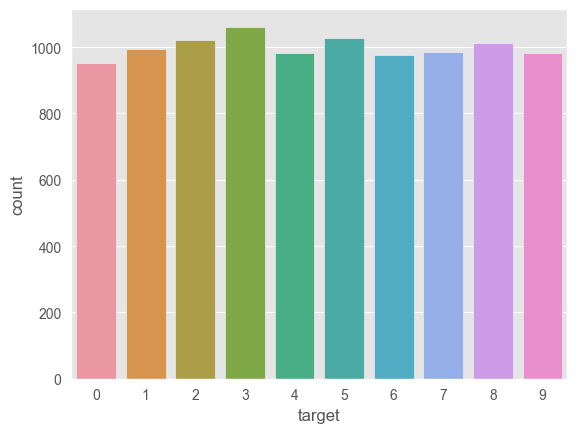

In [80]:
data = RandomDataset(10, 10000, seed=123)
df = get_distribution(data)
sns.countplot(df, x="target")
plt.show()

In [81]:
class FederatedDataset:
    def __init__(self):
        pass

    def federate(
            self,
            worker_ids: list[FlockNodeID]) -> Mapping[FlockNodeID,]:
        return M

In [113]:
def federated_split(
        data: Dataset,
        num_workers: int,
        num_labels: int,
        samples_alpha: float,
        labels_alpha: float,
) -> dict[int, Subset]:
    assert samples_alpha > 0
    assert labels_alpha > 0

    sample_distr = sp.stats.dirichlet(np.full(num_workers, samples_alpha))
    label_distr = sp.stats.dirichlet(np.full(num_labels, labels_alpha))

    workers = list(range(num_workers))
    num_samples_for_workers = (sample_distr.rvs()[0] * len(data)).astype(int)
    label_probs = {w: label_distr.rvs()[0] for w in workers}

    indices: dict[int, list[int]] = defaultdict(list)
    loader = DataLoader(data, batch_size=1)
    worker_samples = defaultdict(int)
    for idx, batch in enumerate(loader):
        _, y = batch
        label = y.item()

        probs = []
        temp_workers = []
        for w in workers:
            if worker_samples[w] < num_samples_for_workers[w]:
                probs.append(label_probs[w][label])
                temp_workers.append(w)
        probs = np.array(probs)
        probs = probs / probs.sum()

        if len(temp_workers) > 0:
            chosen_worker = np.random.choice(temp_workers, p=probs)
            indices[chosen_worker].append(idx)
            worker_samples[chosen_worker] += 1

    subsets = {worker: Subset(data, indices[worker]) for worker in workers}
    return subsets


In [114]:
iid = 1_000_000_000
non_iid = 1
n_workers = 9
fed_data = federated_split(data, n_workers, 10, non_iid, 0.1)
fed_data

{0: <torch.utils.data.dataset.Subset at 0x7fb870945150>,
 1: <torch.utils.data.dataset.Subset at 0x7fb870944640>,
 2: <torch.utils.data.dataset.Subset at 0x7fb8a2f2e320>,
 3: <torch.utils.data.dataset.Subset at 0x7fb8a2f91f30>,
 4: <torch.utils.data.dataset.Subset at 0x7fb8a2f93c10>,
 5: <torch.utils.data.dataset.Subset at 0x7fb8586265f0>,
 6: <torch.utils.data.dataset.Subset at 0x7fb858627430>,
 7: <torch.utils.data.dataset.Subset at 0x7fb87090f130>,
 8: <torch.utils.data.dataset.Subset at 0x7fb87090ff40>}

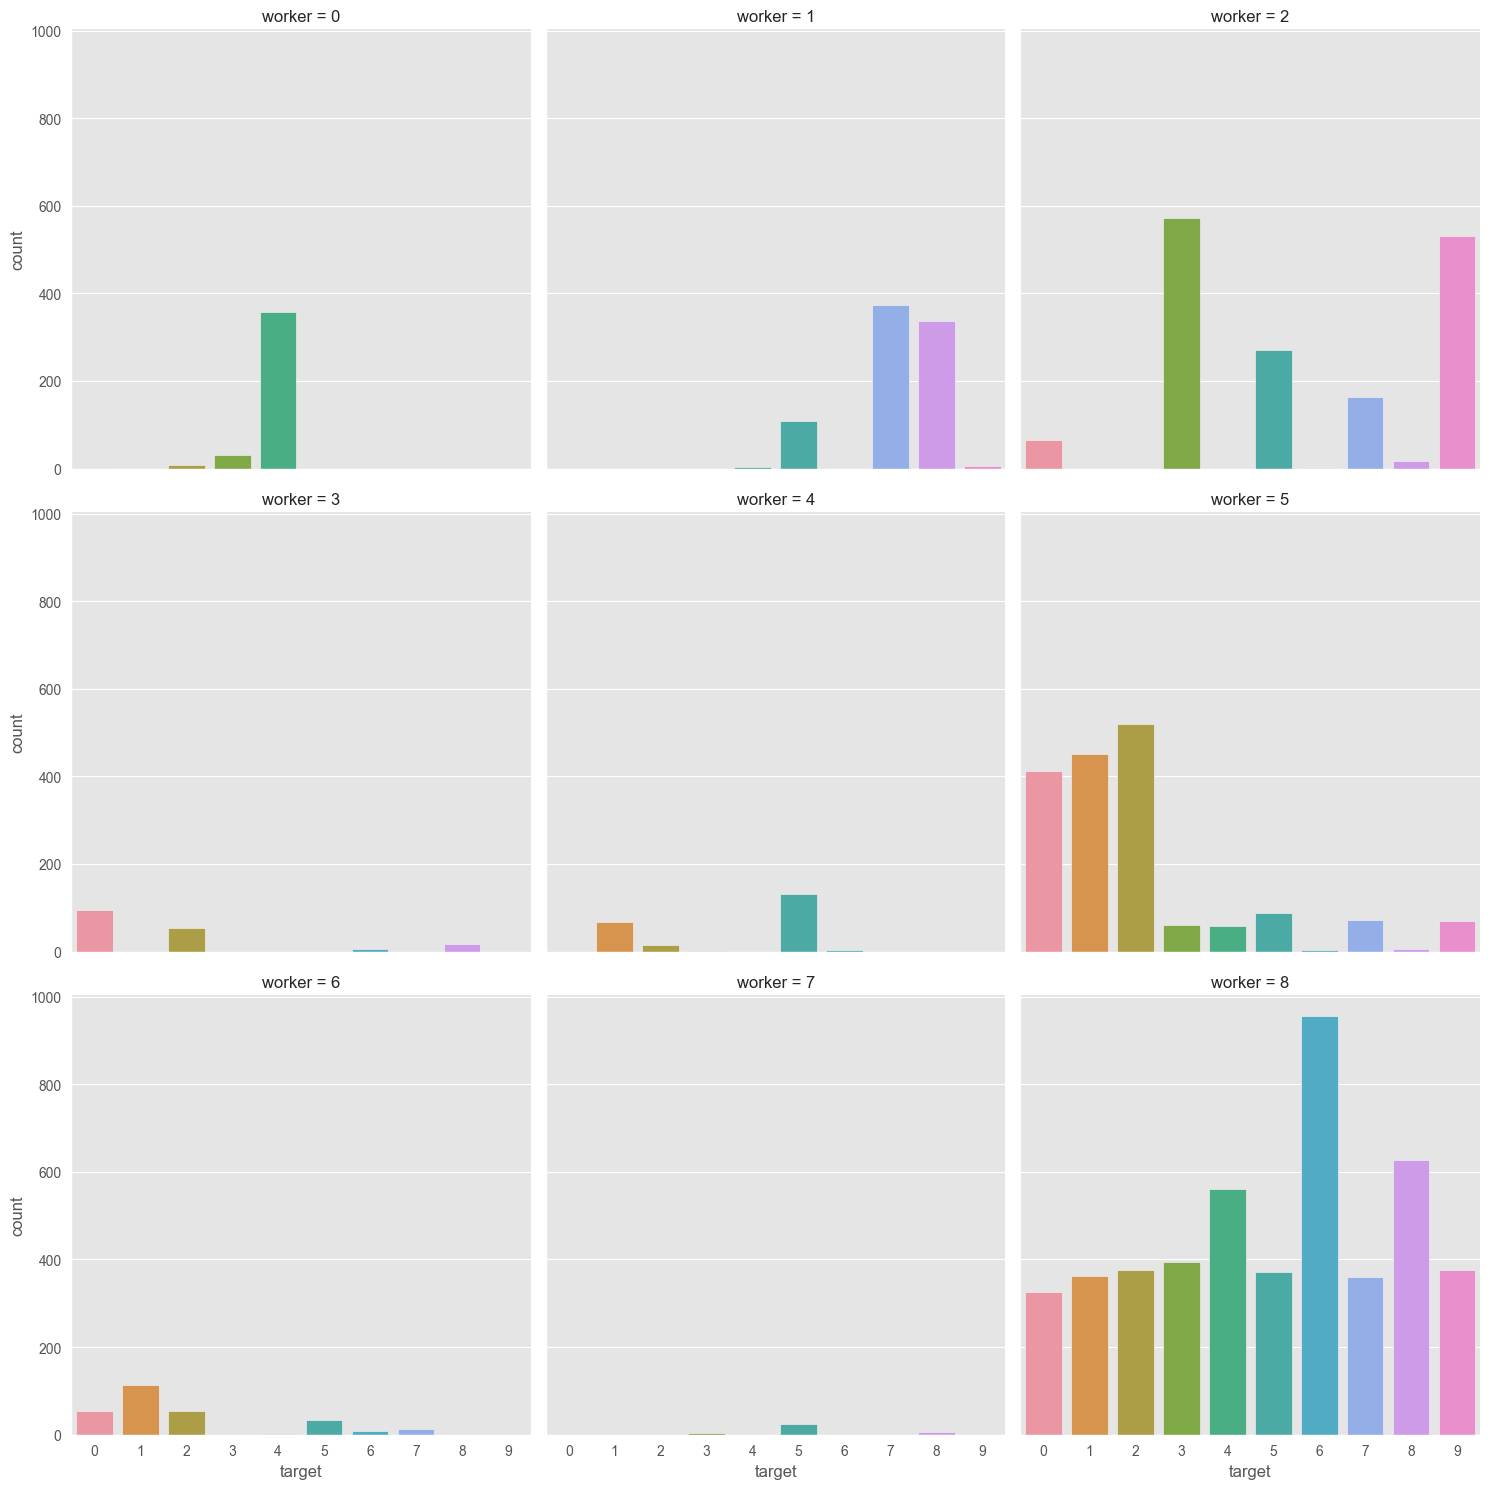

In [115]:
frames = []
for w in range(n_workers):
    df = get_distribution(fed_data[w])
    df["worker"] = w
    frames.append(df)
df = pd.concat(frames).reset_index()

sns.catplot(
    df,
    kind="count",
    col="worker",
    col_wrap=3,
    x="target",
    hue=None,
)
plt.show()